In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_augmentation import random_transform
from random import randint

from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras import applications
from keras.layers import Dense, Conv2D, MaxPooling2D, Reshape, Flatten, Input, merge, subtract, Lambda, Dropout
from keras import backend as K

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/train.csv")

# Shuffle data

In [3]:
from sklearn.utils import shuffle
data = shuffle(data)

In [4]:
len(data)

9850

# Look at example 

In [5]:
from PIL import Image
image = Image.open('data/train/714b7e37.jpg')

In [6]:
np.array(image).shape

(200, 1050, 3)

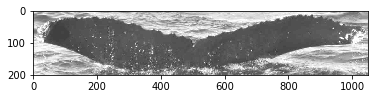

In [7]:
plt.imshow(image)
plt.show()

In [8]:
resize_shape = (128, 128, 3)

In [9]:
file_list = data['Image']
id_list = data['Id']

In [10]:
def get_image(file, shape=(resize_shape[0],resize_shape[1])):
    image = Image.open('data/train/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 2:
        image = np.stack([image]*3,axis=2) 
    return image

In [11]:
image_list = [get_image(f) for f in file_list]

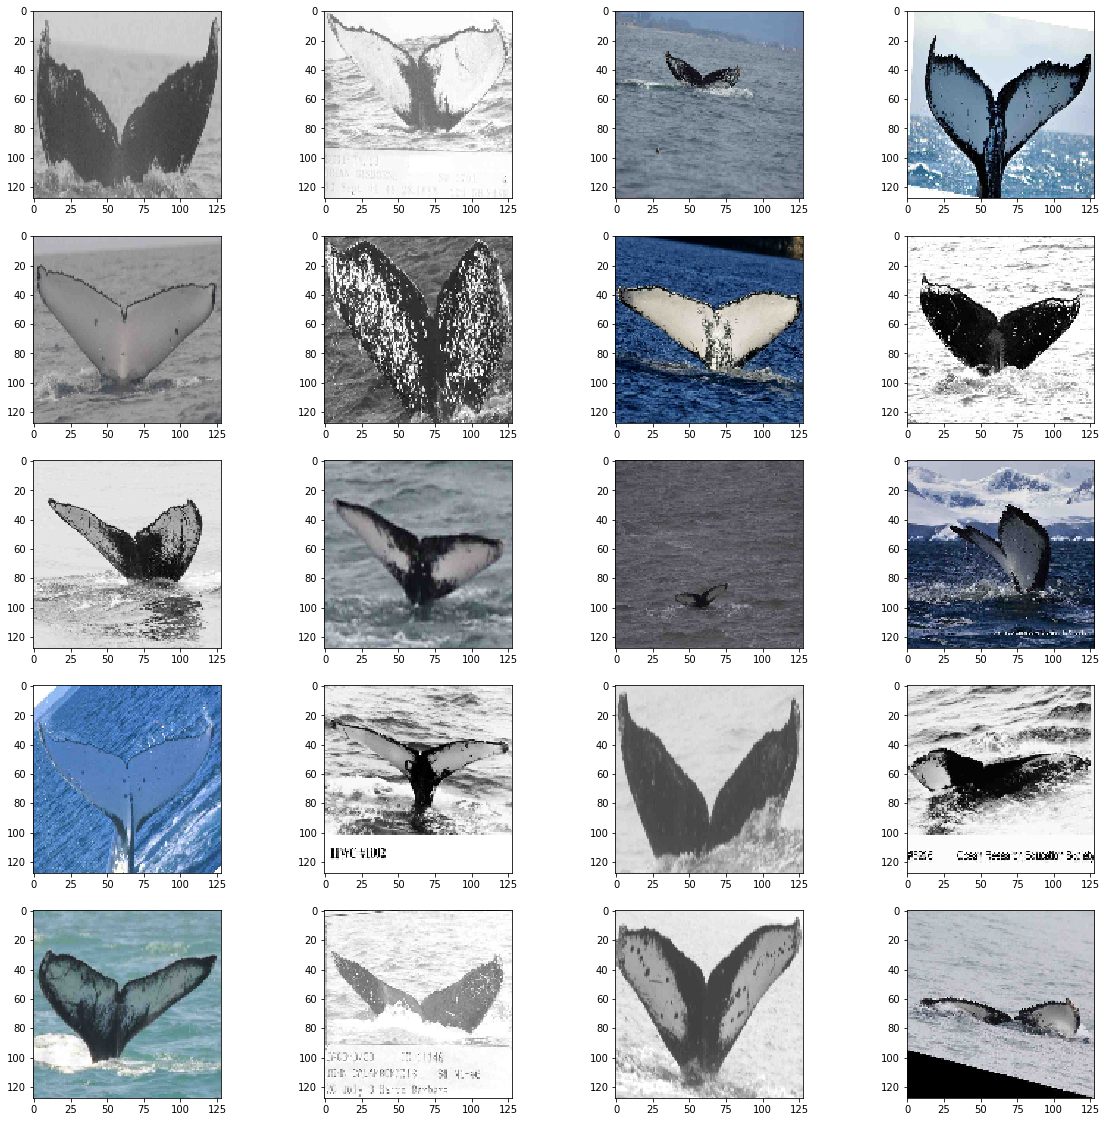

In [12]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = image_list[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [13]:
data['image_array'] = image_list

# Create Test and Train

In [14]:
test_proportion = 0.8
cutoff_index = int(len(data) * test_proportion)

training_data = data.iloc[:cutoff_index].reset_index(drop=True)
test_data = data.iloc[cutoff_index:].reset_index(drop=True)

In [15]:
from collections import Counter

training_counts = Counter(training_data['Id'])
training_data['Id_count'] = training_data.apply(lambda x: training_counts.get(x["Id"]), axis=1)
test_counts = Counter(test_data['Id'])
test_data['Id_count'] = test_data.apply(lambda x: test_counts.get(x["Id"]), axis=1)

# Create generator

In [16]:
def get_triple(len_data, data_images, data_ids, anchor_condition, augment=True):    
    anchor_index = np.random.choice(anchor_condition.index[anchor_condition])    
    anchor_image = data_images[anchor_index]
    anchor_id = data_ids[anchor_index]   

    same_id = anchor_id    
    same_id_indices = (data_ids == anchor_id)
    same_id_index = np.random.choice(same_id_indices.index[same_id_indices])
    same_image = data_images[same_id_index]
    
    different_id = anchor_id    
    while (anchor_id == different_id):
        different_index = randint(0,len_data-1)
        different_id = data_ids[different_index]
    
    different_image = data_images[different_index]
    
    if augment:
        anchor_image = random_transform(anchor_image)
        same_image = random_transform(same_image)
        different_image = random_transform(different_image)
    return anchor_image, same_image, different_image

In [17]:
def triple_generator(batch_size, data, resize_shape, augment=True):    
    len_data = len(data)
    data_images = np.stack(data['image_array'])
    data_ids = data['Id']    
    anchor_condition = (data['Id_count'] > 1) & (data_ids != 'new_whale')        
    
    while True:
        anchor_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        same_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        different_image_batch = np.zeros((batch_size, resize_shape[0],resize_shape[1],resize_shape[2]))
        for i in range(batch_size):
            anchor_batch[i,:,:,:], same_image_batch[i,:,:,:], different_image_batch[i,:,:,:] = get_triple(
                    len_data, data_images, data_ids, anchor_condition, augment)

        batches = [anchor_batch, same_image_batch, different_image_batch]
        yield batches, np.ones(batch_size)

# Create the network

In [18]:
input_shape = resize_shape
anchor_input = Input(input_shape, name='anchor_input')
same_category_input = Input(input_shape, name='positive_input')
different_category_input = Input(input_shape, name='negative_input')

In [19]:
def triplet_loss(X):    
    margin = 3    
    anchor_embedding, same_embedding, different_embedding = X    
    positive_distance = K.square(anchor_embedding - same_embedding)
    negative_distance = K.square(anchor_embedding - different_embedding)    
    positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
    negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)    
    loss = K.maximum(0.0, margin + positive_distance - negative_distance)   
    return K.mean(loss)
    
convnet = Sequential(name='convnet')
convnet.add(Conv2D(filters=8, input_shape=(
    resize_shape[0],resize_shape[1],resize_shape[2],), kernel_size=5, activation='relu',name='conv_1'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_1'))
convnet.add(Conv2D(filters=12, kernel_size=3, activation='relu',name='conv_2'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_2'))
convnet.add(Conv2D(filters=16, kernel_size=3, activation='relu',name='conv_3'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_3'))
convnet.add(Conv2D(filters=20, kernel_size=3, activation='relu',name='conv_4'))
convnet.add(Conv2D(filters=32, kernel_size=3, activation='relu',name='conv_5'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_4'))
convnet.add(Flatten())
convnet.add(Dense(units=128, activation='relu',name='dense_1'))
convnet.add(Dense(units=128, activation='relu',name='dense_2'))
convnet.add(Dense(units=64, activation='relu',name='dense_3'))

anchor = convnet(anchor_input)
same = convnet(same_category_input)
different = convnet(different_category_input)

loss = merge(
        [anchor, same, different],
        mode=triplet_loss,
        name='loss',
        output_shape=(1, ))
    
siamese_net = Model(input=[anchor_input,same_category_input, different_category_input],output=loss)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("lo...)`


In [20]:
def identity_loss(y_true, y_pred):
#     return K.mean(y_pred - 0 * y_true)
    return K.mean(y_pred)

In [21]:
# LEARNING_RATE = 0.1
# siamese_net.compile(loss=identity_loss,optimizer=SGD(LEARNING_RATE))
siamese_net.compile(loss=identity_loss,optimizer=Adam())

# Model summary

In [22]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 124, 124, 8)       608       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 62, 62, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 60, 60, 12)        876       
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 30, 30, 12)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 28, 28, 16)        1744      
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 12, 12, 20)        2900      
__________

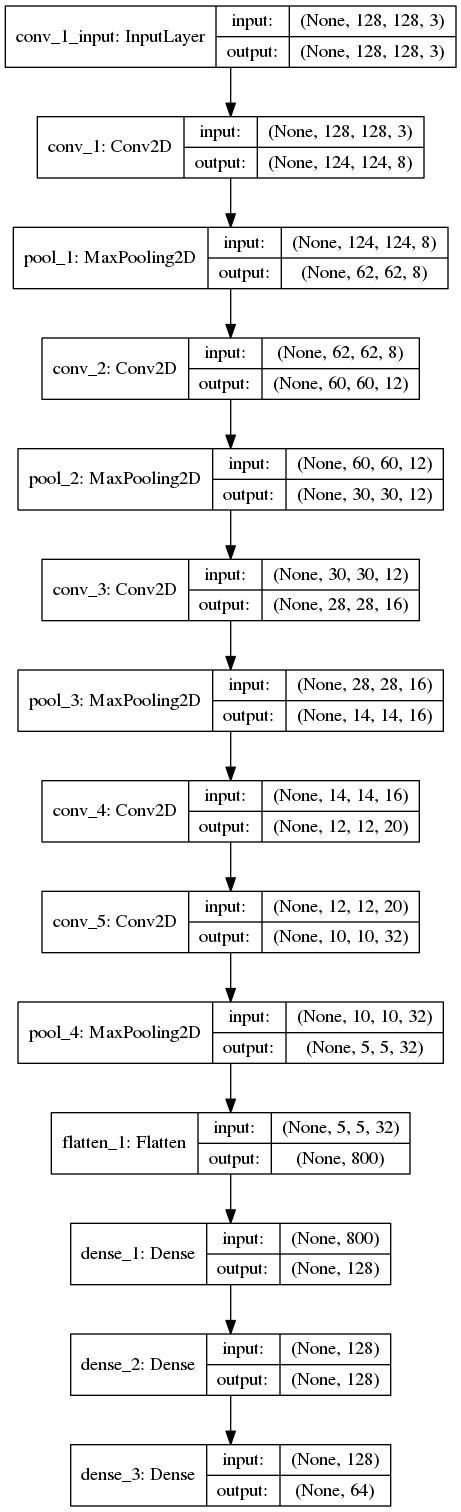

In [23]:
from keras.utils import plot_model
plot_model(convnet, to_file='convnet.png', show_shapes=True)
from IPython.display import Image
Image("convnet.png")

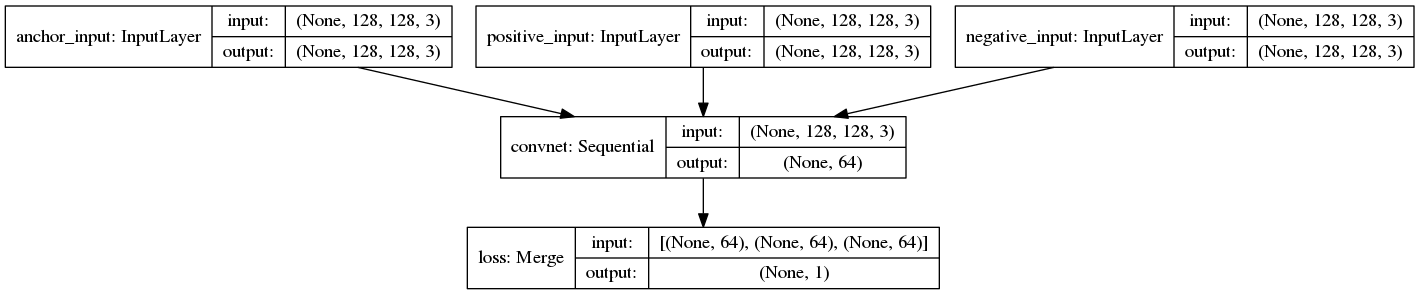

In [24]:
plot_model(siamese_net, to_file='siamese_net.png', show_shapes=True)
Image("siamese_net.png")

# Train the network

In [25]:
from keras.optimizers import Adam, SGD

In [26]:
BATCH_SIZE = 16
training_data_generator = triple_generator(BATCH_SIZE, training_data, resize_shape, augment=True)

In [27]:
history = siamese_net.fit_generator(training_data_generator,
                                    verbose=1, 
                                    epochs=1, 
                                    steps_per_epoch=20,
                                    workers=8,
                                    use_multiprocessing=True)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
20/20 [==============================] - 12s 601ms/step - loss: 2.1492


# Plot loss function 

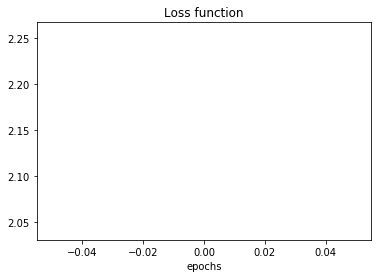

In [28]:
plt.plot(history.history['loss'])
plt.title("Loss function")
plt.xlabel("epochs")
plt.show()

# Load weights

In [29]:
weights_folder = 'weights/' + '2018.02.22 19:17:11' + '/'

convnet.load_weights(weights_folder + 'convnet_weights')
siamese_net.load_weights(weights_folder + 'siamese_weights')

# Calculate loss on test set 

In [30]:
evaluation_data_generator = triple_generator(BATCH_SIZE, test_data, resize_shape, augment=False)
evaluation_steps = 10
metric_names = siamese_net.metrics_names
metric_values = siamese_net.evaluate_generator(evaluation_data_generator, steps=evaluation_steps)
print("Metric names", metric_names)
print("Metric values", metric_values)

Metric names ['loss']
Metric values 0.34351715743541716


# Save weights

In [31]:
import time
import os

now = time.strftime('%Y.%m.%d %H:%M:%S')
weights_directory = "weights/" + now + "/"
if not os.path.exists(weights_directory):
    os.makedirs(weights_directory)

siamese_net.save_weights(weights_directory + "siamese_weights")
convnet.save_weights(weights_directory + "convnet_weights")

# Submission

In [32]:
embedding_list = convnet.predict(np.stack(image_list))

In [33]:
from PIL import Image

def get_sub_image(file, shape=(resize_shape[0],resize_shape[1])):
    image = Image.open('data/test/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 2:
        image = np.stack([image]*3,axis=2) 
    return image


sample_sub = pd.read_csv("data/sample_submission.csv")
submission_file_list = sample_sub['Image']
submission_image_list = [get_sub_image(f) for f in submission_file_list]

In [34]:
submission_embedding_list = convnet.predict(np.stack(submission_image_list))

In [35]:
def remove_duplicates(li):
    my_set = set()
    filtered = []
    for e in li:
        if e not in my_set:
            filtered.append(e)
            my_set.add(e)
    return filtered

def classify(image_embedding, embedding_list, id_list, num_categories=5):
    image_embedding = np.expand_dims(image_embedding, axis=0)
    stacked_image = np.repeat(image_embedding,len(embedding_list),axis=0)
    square_differences = (stacked_image - embedding_list)**2
    scores = np.sum(square_differences, axis=1)
    
    #Take out magic 3. Put in margin.
    
    scores = np.append(scores, [3], axis=0)
    id_list = np.append(id_list, ['new_whale'], axis=0)
    
    sorted_ids = [x for (y,x) in sorted(
        zip(scores,id_list), key=lambda pair: pair[0])]
    
    return ' '.join(remove_duplicates(sorted_ids)[0:num_categories])
    

In [36]:
submission_prediction_list = [classify(image_embedding, embedding_list, id_list) for image_embedding in submission_embedding_list]

In [37]:
submission = pd.DataFrame({'Image': submission_file_list, 'Id': submission_prediction_list}, columns=['Image','Id'])

# Save Results

In [38]:
results_directory = "results/" + now + "/"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
    
submission.to_csv(results_directory + "submission.csv",index=False)

# Visualization

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [40]:
pca = PCA(n_components=2)

In [41]:
def color_from_string(s, vis_ids):
    if s == vis_ids[0]:
        return 'red'
    if s == vis_ids[1]:
        return 'blue'
    if s == vis_ids[2]:
        return 'green'

In [42]:
vis_ids = [x[0] for x in training_counts.most_common(4)][1:4]
vis_filter = id_list.apply(lambda x: x in vis_ids)
vis_embedding_list = embedding_list[vis_filter]
vis_id_list = id_list[vis_filter]
vis_colour_list = [color_from_string(s, vis_ids) for s in vis_id_list]

In [43]:
X_r = pca.fit(vis_embedding_list).transform(vis_embedding_list)

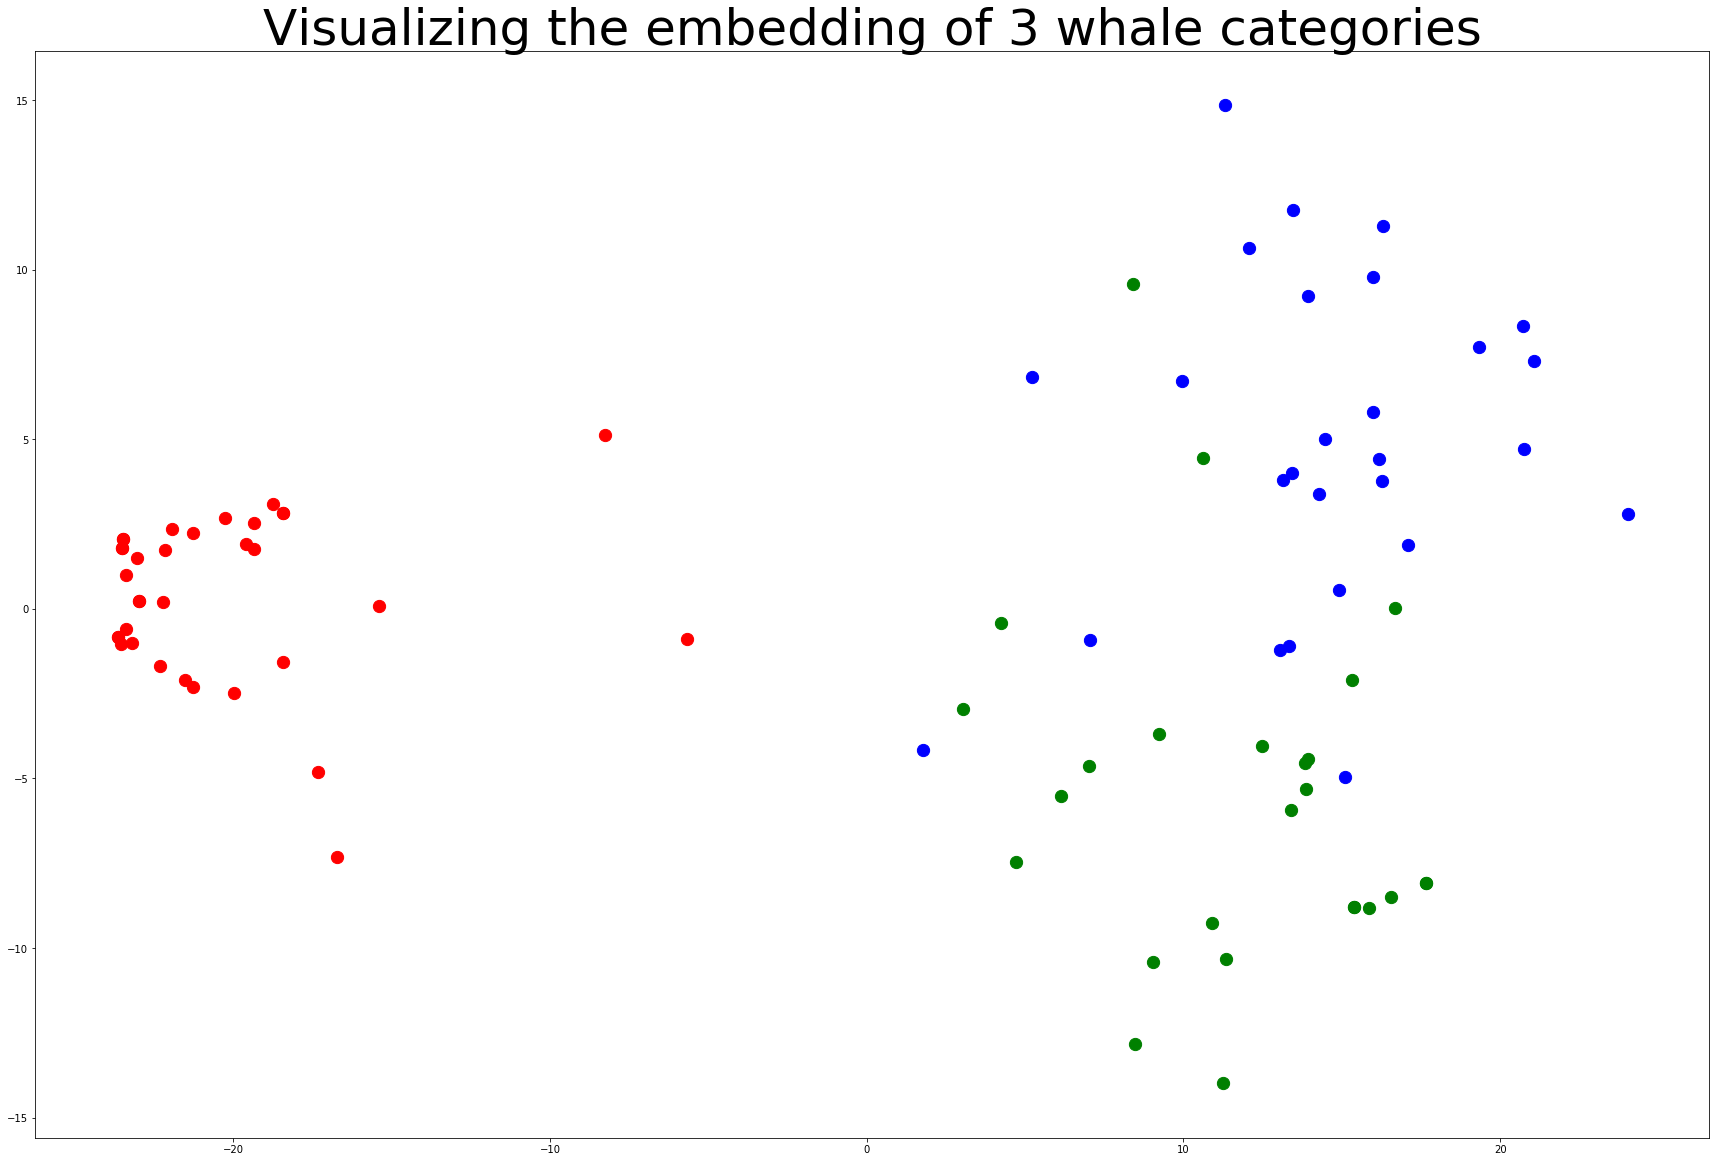

In [44]:
plt.figure(figsize=(30,20))
plt.title("Visualizing the embedding of 3 whale categories", fontsize=50)
for i, c in zip(range(len(vis_id_list)), vis_colour_list):
                 plt.scatter(X_r[i, 0], X_r[i, 1], color=c, s=150)